In [133]:
import pandas as pd
import numpy as np
import glob
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS 
from textblob import TextBlob
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('punkt')
import string

from langdetect import detect_langs

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from textatistic import Textatistic

import spacy

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [104]:
Data = pd.read_csv('Reviews.csv')

In [105]:
Data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [106]:
# Add Helpfulness Column
Data['Helpfulness'] = Data['HelpfulnessNumerator']/Data['HelpfulnessDenominator']
Data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,NaN


In [107]:
# Examine some text:
def show_some_sample_review(Score, Count_of_Records):
    sample_texts = Data[['Summary', 'Text']][Data['Score'] == Score][0:Count_of_Records].reset_index()
    for i in range(0, Count_of_Records):
        print('Summary: ' + sample_texts['Summary'][i] + ' --- Text: ' + sample_texts['Text'][i] + '\n')

In [108]:
show_some_sample_review(1, 10)

Summary: Not as Advertised --- Text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Summary: My Cats Are Not Fans of the New Food --- Text: My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat.

Summary: Nasty No flavor --- Text: The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again

Summary: Don't like it --- Text: This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.

Summary: stale product. --- Text: Arrived in 6 days and were so s

In [109]:
# Check distribution of Score: 
Distribution_Score = Data.groupby(['Score'])[['Text', 'Helpfulness']].count()
Distribution_Score['Percent_People_Indicate_Helpfulness'] = Distribution_Score['Helpfulness']/Distribution_Score['Text']
Distribution_Score

,Text,Helpfulness,Percent_People_Indicate_Helpfulness
Score,,,
1,52268,40002,0.765325
2,29769,19165,0.643791
3,42640,24217,0.567941
4,80655,38639,0.479065
5,363122,176379,0.485729


### Lower score have more users indicate helpfulness. 76% vs 47%

<AxesSubplot:xlabel='Helpfulness', ylabel='Count'>

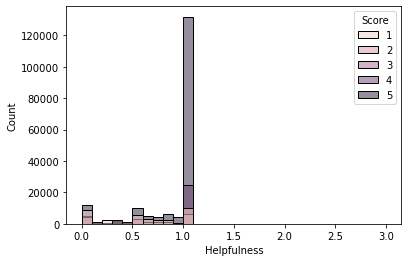

In [110]:
sns.histplot(data = Data, x = 'Helpfulness', hue = 'Score', binwidth = 0.1)

In [139]:
# Filter to only data with Helpfulness value not NAN
Data_Sample = Data[Data['Helpfulness'].notnull()][0:10000].reset_index()
Data_Sample

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
2,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
3,8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0
4,10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19509,19510,B001EO5QO6,A3VL263FW0O1JL,Rivka,1,1,5,1198368000,Fresh and delicious!,Our health care provider recommended eating 1 ...,1.0
9996,19510,19511,B001EO5QO6,A23MGS2U5PPBY1,"Ethann Makinenni ""Ethann""",0,1,4,1173571200,They are great,"I eat these nuts daily, right after I eat some...",0.0
9997,19512,19513,B000E3VANE,A1F7SX3GNVBNE3,"Joshua G. Feldman ""Technophile""",6,6,5,1181001600,This is the best flavor of Zatarain's - univer...,I love all the flavors of Zatarain's. I love ...,1.0
9998,19513,19514,B000E3VANE,A5N60O5P83HSX,A. Newhouse,1,1,5,1311897600,"Great flavor, convenient to buy by the case",These are the same box mixes that I've been bu...,1.0


# Step 1: Feature creation

In [140]:
# Tokenize each item in the Text column
word_tokens = [word_tokenize(review) for review in Data_Sample.Text]
sent_tokens = [sent_tokenize(review) for review in Data_Sample.Text]
blob = [TextBlob(review) for review in Data_Sample.Text]

# Create an empty list to store the length of the Text
len_tokens = []
len_sent = []
Count_Punct = []
polarity = []
subjectivity = []
Readablitys = []

# Iterate over the word_tokens list and determine the length of each item
for i in range(len(word_tokens)):
    len_tokens.append(len(word_tokens[i]))
    len_sent.append(len(sent_tokens[i]))
    polarity.append(blob[i].sentiment[0])
    subjectivity.append(blob[i].sentiment[1])
    
    punctuation_count = 0
    for word in word_tokens[i]:
        if word in string.punctuation:
            punctuation_count += 1
    Count_Punct.append(punctuation_count)
    
    if len(word_tokens[i]) > 10 and len(sent_tokens[i]) >= 2 :
        Readablity = Textatistic(Data_Sample['Text'][i]).scores['flesch_score']
    else:
        Readablity = 100
    Readablitys.append(Readablity)

# Create a new feature for the lengh of each review
Data_Sample['n_words'] = len_tokens 
Data_Sample['n_sents'] = len_sent 
Data_Sample['polarity'] = polarity 
Data_Sample['subjectivity'] = subjectivity 
Data_Sample['n_punct'] = Count_Punct 
Data_Sample['Readablity'] = Readablitys 


In [141]:
Data_Sample

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,n_words,n_sents,polarity,subjectivity,n_punct,Readablity
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,51,3,0.450000,0.433333,3,83.082500
1,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,109,8,0.133571,0.448571,15,93.468140
2,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,46,3,0.166667,0.533333,5,77.412114
3,8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,29,3,0.428571,0.545238,2,99.278462
4,10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0,184,4,0.208594,0.682478,29,87.806431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19509,19510,B001EO5QO6,A3VL263FW0O1JL,Rivka,1,1,5,1198368000,Fresh and delicious!,Our health care provider recommended eating 1 ...,1.0,69,4,0.071581,0.411467,4,86.218173
9996,19510,19511,B001EO5QO6,A23MGS2U5PPBY1,"Ethann Makinenni ""Ethann""",0,1,4,1173571200,They are great,"I eat these nuts daily, right after I eat some...",0.0,28,2,0.571429,0.633929,4,88.905000
9997,19512,19513,B000E3VANE,A1F7SX3GNVBNE3,"Joshua G. Feldman ""Technophile""",6,6,5,1181001600,This is the best flavor of Zatarain's - univer...,I love all the flavors of Zatarain's. I love ...,1.0,287,19,0.158333,0.390946,36,89.644084
9998,19513,19514,B000E3VANE,A5N60O5P83HSX,A. Newhouse,1,1,5,1311897600,"Great flavor, convenient to buy by the case",These are the same box mixes that I've been bu...,1.0,146,5,0.143348,0.412798,23,82.019130


In [142]:
Data_Sample['Readablity'].min()

30.320191256830626

In [143]:
x = Data_Sample['Text'][Data_Sample['Readablity'] <60].reset_index()
x['Text'][2]

'I purchased this product because of its name, "Rumford NATURALS Corn Starch" (the word "Naturals" appears large and clear on the pictured product label). Also, the Amazon description said it was made from "Non-Genetically Modified Corn". The label on the product that I ACTUALLY received does NOT say Rumford NATURALS, but it is still MADE WITH Non-Genetically Modified Corn. I say "made with" because this product now contains more than ONE ingredient. Its ingredients are: Cornstarch, Calcium Sulfate*, and ONE of the suggested servings (1 Tblsp) contains 15% of the "Daily Value" of CALCIUM. That makes this product potentially a good source for dietary calcium supplementation. ON THE OTHER HAND, for persons who must restrict their calcium intake (example, some persons with kidney stones), it can pose a potential problem, even danger. Amazon provides themselves with a nice "out" for this. They list the following: Legal Disclaimer: "Actual product packaging and materials may contain more an

In [144]:
# Load the en_core_web_m model
nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Function to preprocess text
def preprocess(text):
        # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)

# Apply preprocess to ted['transcript']
Data_Sample['Text_Cleaned'] = Data_Sample['Text'].apply(preprocess)

In [145]:
def proper_nouns(text, model=nlp):
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of proper nouns
    return pos.count('PROPN')

def nouns(text, model=nlp):
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of other nouns
    return pos.count('NOUN')

# Apply Count of PRORN AND NOUN columns
Data_Sample['n_PROPN'] = Data_Sample['Text'].apply(proper_nouns)
Data_Sample['n_NOUN'] = Data_Sample['Text'].apply(nouns)

In [146]:
Data_Sample

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,...,Helpfulness,n_words,n_sents,polarity,subjectivity,n_punct,Readablity,Text_Cleaned,n_PROPN,n_NOUN
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,...,1.0,51,3,0.450000,0.433333,3,83.082500,I buy Vitality dog food product find good qual...,2,8
1,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",...,1.0,109,8,0.133571,0.448571,15,93.468140,confection century light pillowy citrus gelati...,11,12
2,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,...,1.0,46,3,0.166667,0.533333,5,77.412114,look secret ingredient Robitussin I believe I ...,4,5
3,8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,...,1.0,29,3,0.428571,0.545238,2,99.278462,right I sprout cat eat grass love I rotate Whe...,2,2
4,10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,...,1.0,184,4,0.208594,0.682478,29,87.806431,I know cactus tequila unique combination ingre...,6,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19509,19510,B001EO5QO6,A3VL263FW0O1JL,Rivka,1,1,5,1198368000,Fresh and delicious!,...,1.0,69,4,0.071581,0.411467,4,86.218173,health care provider recommend eat ounce raw a...,0,14
9996,19510,19511,B001EO5QO6,A23MGS2U5PPBY1,"Ethann Makinenni ""Ethann""",0,1,4,1173571200,They are great,...,0.0,28,2,0.571429,0.633929,4,88.905000,I eat nuts daily right I eat fruit wonderful w...,0,1
9997,19512,19513,B000E3VANE,A1F7SX3GNVBNE3,"Joshua G. Feldman ""Technophile""",6,6,5,1181001600,This is the best flavor of Zatarain's - univer...,...,1.0,287,19,0.158333,0.390946,36,89.644084,I love flavor Zatarain I love cook cajun style...,8,50
9998,19513,19514,B000E3VANE,A5N60O5P83HSX,A. Newhouse,1,1,5,1311897600,"Great flavor, convenient to buy by the case",...,1.0,146,5,0.143348,0.412798,23,82.019130,box mix I buy locally good thing like flavor u...,3,22


In [ ]:
# Step 2: Building a vectorizer

In [147]:
# Since TfidfVectorizer get ride of the too common words, no need to remove stopwords
# Build the vectorizer
vect = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2), max_features=200, token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(Data_Sample.Text_Cleaned)
# Create sparse matrix from the vectorizer
X = vect.transform(Data_Sample.Text_Cleaned)
# Create a DataFrame
reviews_transformed = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
print('Top 5 rows of the DataFrame: \n', reviews_transformed.head())

Top 5 rows of the DataFrame: 
    actually  add  amazon  arrive      away  baby  bad  bag  bean  big  ...   
0       0.0  0.0     0.0     0.0  0.000000   0.0  0.0  0.0   0.0  0.0  ...  \
1       0.0  0.0     0.0     0.0  0.000000   0.0  0.0  0.0   0.0  0.0  ...   
2       0.0  0.0     0.0     0.0  0.000000   0.0  0.0  0.0   0.0  0.0  ...   
3       0.0  0.0     0.0     0.0  0.000000   0.0  0.0  0.0   0.0  0.0  ...   
4       0.0  0.0     0.0     0.0  0.140601   0.0  0.0  0.0   0.0  0.0  ...   

       want  water  way  week  white   wo  wonderful  work  worth  year  
0  0.000000    0.0  0.0   0.0    0.0  0.0        0.0   0.0    0.0   0.0  
1  0.000000    0.0  0.0   0.0    0.0  0.0        0.0   0.0    0.0   0.0  
2  0.000000    0.0  0.0   0.0    0.0  0.0        0.0   0.0    0.0   0.0  
3  0.000000    0.0  0.0   0.0    0.0  0.0        0.0   0.0    0.0   0.0  
4  0.216734    0.0  0.0   0.0    0.0  0.0        0.0   0.0    0.0   0.0  

[5 rows x 200 columns]


In [148]:
Other_Features = Data_Sample[['n_words', 'n_sents', 'polarity', 'subjectivity','n_punct', 'Readablity', 'n_PROPN', 'n_NOUN']]
# Combine the vectorizer with other feature columns:
Features = pd.concat([reviews_transformed, Other_Features], axis=1)
Features

,actually,add,amazon,arrive,away,baby,bad,bag,bean,big,...,worth,year,n_words,n_sents,polarity,subjectivity,n_punct,Readablity,n_PROPN,n_NOUN
0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,51,3,0.450000,0.433333,3,83.082500,2,8
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,109,8,0.133571,0.448571,15,93.468140,11,12
2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,46,3,0.166667,0.533333,5,77.412114,4,5
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,29,3,0.428571,0.545238,2,99.278462,2,2
4,0.000000,0.000000,0.000000,0.0,0.140601,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,184,4,0.208594,0.682478,29,87.806431,6,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.248731,0.0,0.000000,0.000000,...,0.0,0.000000,69,4,0.071581,0.411467,4,86.218173,0,14
9996,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,28,2,0.571429,0.633929,4,88.905000,0,1
9997,0.118842,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.134478,0.114217,...,0.0,0.000000,287,19,0.158333,0.390946,36,89.644084,8,50
9998,0.000000,0.155230,0.146525,0.0,0.000000,0.0,0.000000,0.0,0.219713,0.000000,...,0.0,0.000000,146,5,0.143348,0.412798,23,82.019130,3,22


In [ ]:
# Step 3: Building a Regression Model

In [149]:
# Define X and y
y = Data_Sample.Helpfulness
X = Features
# Train/test split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=456)

In [150]:
# linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict the labels
y_predicted = lr.predict(X_test)

# Print accuracy score and confusion matrix on test set
# print('Accuracy on the test set: ', accuracy_score(y_test, y_predicted))
# print(confusion_matrix(y_test, y_predicted)/len(y_test))

# print mean square error
mse = mean_squared_error(y_test, y_predicted)
print(f"Mean squared error: {mse}")

# R-squared (R2)
r2 = r2_score(y_test, y_predicted)
print(f"R-squared: {r2}")

Mean squared error: 0.10942663921655779
R-squared: 0.05722572740066745


In [151]:
# ridge regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predict the labels
y_predicted = ridge.predict(X_test)

# print mean square error
mse = mean_squared_error(y_test, y_predicted)
print(f"Mean squared error: {mse}")

# R-squared (R2)
r2 = r2_score(y_test, y_predicted)
print(f"R-squared: {r2}")

Mean squared error: 0.10907222363803055
R-squared: 0.06027922416924347


In [152]:
# SVR model
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(X_train, y_train)

# Predict the labels
y_predicted = svr.predict(X_test)

# print mean square error
mse = mean_squared_error(y_test, y_predicted)
print(f"Mean squared error: {mse}")

# R-squared (R2)
r2 = r2_score(y_test, y_predicted)
print(f"R-squared: {r2}")

Mean squared error: 0.12537442168780513
R-squared: -0.08017371323414602


In [153]:
# random forest regression model
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

# Predict the labels
y_predicted = rfr.predict(X_test)

# print mean square error
mse = mean_squared_error(y_test, y_predicted)
print(f"Mean squared error: {mse}")

# R-squared (R2)
r2 = r2_score(y_test, y_predicted)
print(f"R-squared: {r2}")

Mean squared error: 0.10534827507087274
R-squared: 0.09236321145730675


In [154]:
# gradient boosting regression model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Predict the labels
y_predicted = gb_model.predict(X_test)

# print mean square error
mse = mean_squared_error(y_test, y_predicted)
print(f"Mean squared error: {mse}")

# R-squared (R2)
r2 = r2_score(y_test, y_predicted)
print(f"R-squared: {r2}")

Mean squared error: 0.1052881443302189
R-squared: 0.09288127283328118
